# B. State purification with qubit-mediated measurement

In [1]:
# ruff: noqa
import os

os.sys.path.append("..")
from feedback_grape.fgrape import optimize_pulse_with_feedback
import jax.numpy as jnp

## The cavity is initially in a  mixed state --> Goal is to purify the state

We are trying to maximize the property determined by $tr (\rho_{\text{cav}}^2)$ which is the purity

In the following, we consider an adaptive measurement
scheme, demonstrated in a series of experiments on Rydberg atoms interacting
with microwave cavities. In this scheme, the
cavity is coupled to an ancilla qubit, which can then be
read out to update our knowledge of the quantum state of
the cavity.

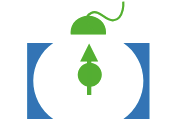

In [2]:
# initial state is a thermal state
n_average = 5
N_cavity = 30
# natural logarithm
beta = jnp.log((1 / n_average) + 1)
diags = jnp.exp(-beta * jnp.arange(N_cavity))
normalized_diags = diags / jnp.sum(diags, axis=0)
rho_cav = jnp.diag(normalized_diags)

### Now the thing is here, we don't need a rho_final because the purity or the reward that we want to maximize is $tr (\rho_{\text{cav}}^2)$.
Unlike fidelity expressions which wants to find how close to states are

## Next Step is to construct our POVM

In [3]:
from feedback_grape.utils.operators import cosm, sinm

In [4]:
from feedback_grape.utils.operators import create, destroy
import jax


def povm_measure_operator(measurement_outcome, gamma, delta):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    # TODO: see if there is a better way other than flattening
    number_operator = create(N_cavity) @ destroy(N_cavity)
    angle = (gamma * number_operator) + delta / 2
    return jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )

In [37]:
# TODO: Have a default NN and then give user the ability to supply a model or a function
# With log p terms: 0.0.9984141684258416
# Without log p terms: 0.999796307373522
# Answer: why does RNN outputs two the same, then two the same, then two the same and so on? -> calculate during forward proagation then again during back_propagation
from feedback_grape.fgrape_helpers import RNN
import numpy as np
# Create an array of dicts with random initializations between -2pi and 2pi

initial_params = {
    "POVM": [0.1, -3 * jnp.pi / 2],
}
result = optimize_pulse_with_feedback(
    U_0=rho_cav,
    C_target=rho_cav,
    parameterized_gates=[povm_measure_operator],
    measurement_indices=[0],
    initial_params=initial_params,
    num_time_steps=5,
    mode="lookup",
    goal="both",
    optimizer="adam",
    max_iter=100,
    convergence_threshold=1e-20,
    learning_rate=0.01,
    type="density",
    batch_size=1,
    RNN=RNN,
)

Iteration 0, Loss: -0.880897
Iteration 10, Loss: 0.019779
Iteration 20, Loss: -0.975098
Iteration 30, Loss: 0.621479
Iteration 40, Loss: 0.557623
Iteration 50, Loss: -1.008779
Iteration 60, Loss: -0.117227
Iteration 70, Loss: 0.301054
Iteration 80, Loss: 0.365245
Iteration 90, Loss: 0.198626


In [38]:
result

FgResult(optimized_rnn_parameters=[[Array([-0.3576333 , -1.70199759], dtype=float64), Array([-2.40187964, -0.22300586], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64)], [Array([-0.79222729, -1.78763607], dtype=float64), Array([-2.44865437, -0.3424419 ], dtype=float64), Array([-0.55615061, -2.18935016], dtype=float64), Array([ 2.2875433 , -0.26903699], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=

In [39]:
print(result.final_fidelity)

0.6193506470978295


In [40]:
print(result.final_state)

[[[ 1.97451030e-03+0.j -1.44201903e-02+0.j -9.78275428e-03+0.j ...
    2.46637883e-04+0.j -5.09549612e-04+0.j -2.75280096e-03+0.j]
  [-1.44201903e-02+0.j  1.64619091e-01+0.j -9.45489165e-02+0.j ...
   -1.11299158e-03+0.j  8.45690076e-04+0.j  9.86777788e-03+0.j]
  [-9.78275428e-03+0.j -9.45489165e-02+0.j  5.99788835e-01+0.j ...
   -8.97098955e-04+0.j  7.92059530e-03+0.j  2.69899315e-02+0.j]
  ...
  [ 2.46637883e-04+0.j -1.11299158e-03+0.j -8.97098955e-04+0.j ...
    8.17101865e-04+0.j -1.17901629e-03+0.j -5.13690780e-03+0.j]
  [-5.09549612e-04+0.j  8.45690076e-04+0.j  7.92059530e-03+0.j ...
   -1.17901629e-03+0.j  2.20232785e-03+0.j  7.49312662e-03+0.j]
  [-2.75280096e-03+0.j  9.86777788e-03+0.j  2.69899315e-02+0.j ...
   -5.13690780e-03+0.j  7.49312662e-03+0.j  4.05108896e-02+0.j]]

 [[ 1.79012645e-02+0.j  2.67443112e-02+0.j  2.60266170e-02+0.j ...
    1.71911374e-03+0.j  2.21536618e-03+0.j  1.74519630e-03+0.j]
  [ 2.67443112e-02+0.j  5.48324796e-02+0.j  2.72696361e-02+0.j ...
    2.01

In [41]:
# 0.33295458963455277
print(result.final_purity)

0.40357595173908223


In [42]:
from feedback_grape.utils.purity import purity

print("initial purity:", purity(rho=rho_cav))
for i, state in enumerate(result.final_state):
    print(f"Purity of state {i}:", purity(rho=state))

initial purity: 0.09167828042260612
Purity of state 0: 0.42990913640226713
Purity of state 1: 0.3898462288836188
Purity of state 2: 0.31834127449734784
Purity of state 3: 0.31834127449734784
Purity of state 4: 0.5124833742099376
Purity of state 5: 0.5124833742099376
Purity of state 6: 0.5124833742099376
Purity of state 7: 0.4404863419540517
Purity of state 8: 0.8105967658836633
Purity of state 9: 0.36396760766337055
Purity of state 10: 0.3898462288836188
Purity of state 11: 0.31834127449734784
Purity of state 12: 0.8105967658836633
Purity of state 13: 0.3699782638750059
Purity of state 14: 0.2259744151468883
Purity of state 15: 0.3898462288836188
Purity of state 16: 0.36396760766337055
Purity of state 17: 0.2259744151468883
Purity of state 18: 0.2792951050999974
Purity of state 19: 0.36396760766337055
Purity of state 20: 0.42990913640226713
Purity of state 21: 0.8105967658836633
Purity of state 22: 0.25677709994626646
Purity of state 23: 0.8105967658836633
Purity of state 24: 0.5124833

In [33]:
result.returned_params

[[Array([[ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         ...,
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898]], dtype=float64)],
 [Array([[-0.51809726, -1.73690115],
         [-0.51809726, -1.73690115],
         [-0.51809726, -1.73690115],
         ...,
         [-0.51809726, -1.73690115],
         [-0.51809726, -1.73690115],
         [-0.51809726, -1.73690115]], dtype=float64)],
 [Array([[-0.532909  , -1.72342567],
         [-2.43539098, -0.35432004],
         [-2.43539098, -0.35432004],
         ...,
         [-0.532909  , -1.72342567],
         [-0.532909  , -1.72342567],
         [-0.532909  , -1.72342567]], dtype=float64)],
 [Array([[-2.48699595, -0.49299859],
         [-0.4786155 , -2.10928923],
         [-0.4786155 , -2.10928923],
         ...,
         [-0.5485226 , -1.76725427],
         [-0.5485226 , -1.76725427],
         [-0.5485226 , -1.76725427]], d

In [34]:
print(jax.random.PRNGKey(9))
time_step_keys = jax.random.split(jax.random.PRNGKey(9), 5)
print(time_step_keys)
for key in time_step_keys:
    print(jax.random.uniform(key))

[0 9]
[[2822284597 2722679661]
 [ 143080583 4281670255]
 [2676565412 4109519897]
 [1877436067 1979300842]
 [3339921199 4267639851]]
0.16232149317805766
0.07829857808883056
0.8422083576204116
0.23698051656885277
0.33005660981143814


In [35]:
from feedback_grape.fgrape import povm
import random

time_steps = 5

rho = rho_cav
print("initial purity:", purity(rho=rho))

rand_num = random.randint(1, 50)

time_step_keys = jax.random.split(jax.random.PRNGKey(rand_num), time_steps)
for i in range(time_steps):
    params = result.returned_params[i][0]
    print(f"params for time step {i}:", params[0])
    rho, _, _ = povm(rho, povm_measure_operator, params[0], time_step_keys[i])
    print(f"purity of rho after time step {i}", purity(rho=rho))
final_rho_cav = rho

initial purity: 0.09167828042260612
params for time step 0: [ 0.1        -4.71238898]
purity of rho after time step 0 0.13627289474831314
params for time step 1: [-0.51809726 -1.73690115]
purity of rho after time step 1 0.21920821486348993
params for time step 2: [-0.532909   -1.72342567]
purity of rho after time step 2 0.2807182676519425
params for time step 3: [-2.48699595 -0.49299859]
purity of rho after time step 3 0.3562683314543313
params for time step 4: [ 2.26798865 -0.49939585]
purity of rho after time step 4 0.26135237758708


In [36]:
from feedback_grape.utils.povm import (
    _probability_of_a_measurement_outcome_given_a_certain_state,
)

variables = jnp.array([0.1, -3 * jnp.pi / 2])
# variables_2 = {
#     "gamma": 0.1,
#     "delta": -3 * jnp.pi / 2,
# }
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, -1, povm_measure_operator, variables
    )
)
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, 1, povm_measure_operator, variables
    )
)

0.2582716410467118
0.7417283589532875


### Check stash for replacement of dict implementation

In [15]:
print("Final state after application of amplitudes:", final_rho_cav)

Final state after application of amplitudes: [[ 1.65469379e-03+0.j -1.57657843e-03+0.j -4.01392338e-03+0.j
   1.46213932e-02+0.j  3.40458012e-04+0.j  2.07992949e-04+0.j
   3.07232740e-04+0.j  1.42377623e-04+0.j  8.67914280e-04+0.j
   2.86007345e-04+0.j -3.13706170e-04+0.j  2.51430744e-03+0.j
   8.81080130e-04+0.j -2.27078135e-04+0.j -1.00527512e-03+0.j
   2.09203999e-04+0.j -3.51980369e-04+0.j  1.68690841e-03+0.j
  -1.87893376e-04+0.j  2.38717571e-04+0.j -5.44921352e-04+0.j
   8.15961561e-04+0.j  4.56491660e-05+0.j -3.73541688e-04+0.j
   3.93710210e-04+0.j -1.00832462e-04+0.j -1.35294860e-04+0.j
   1.10547642e-04+0.j -3.76692579e-04+0.j  2.49704270e-05+0.j]
 [-1.57657843e-03+0.j  2.42176654e-03+0.j  1.65329335e-03+0.j
  -2.23415133e-02+0.j -1.75104491e-03+0.j -4.86753518e-04+0.j
   3.99445391e-04+0.j  1.42665857e-04+0.j -8.65612146e-04+0.j
  -1.87230148e-04+0.j -1.52712911e-04+0.j -1.55327453e-03+0.j
  -4.28300508e-04+0.j -2.00015300e-03+0.j -2.06502457e-04+0.j
  -1.59860232e-04+0.j -5

In [16]:
print("Final state from solver:", result.final_state)

Final state from solver: [[[ 1.63467070e-02+0.j -2.51544596e-02+0.j -1.86441202e-02+0.j ...
   -3.01091564e-03+0.j -3.45087707e-03+0.j -3.22137992e-04+0.j]
  [-2.51544596e-02+0.j  5.54772050e-02+0.j  1.37062261e-02+0.j ...
    9.01418935e-03+0.j  8.69601833e-03+0.j  7.89698459e-04+0.j]
  [-1.86441202e-02+0.j  1.37062261e-02+0.j  8.46714425e-02+0.j ...
   -1.04063398e-02+0.j -6.87117887e-03+0.j -6.08533475e-04+0.j]
  ...
  [-3.01091564e-03+0.j  9.01418935e-03+0.j -1.04063398e-02+0.j ...
    4.50845189e-02+0.j  3.04164111e-02+0.j  2.56960619e-03+0.j]
  [-3.45087707e-03+0.j  8.69601833e-03+0.j -6.87117887e-03+0.j ...
    3.04164111e-02+0.j  3.09615081e-02+0.j  2.38228656e-03+0.j]
  [-3.22137992e-04+0.j  7.89698459e-04+0.j -6.08533475e-04+0.j ...
    2.56960619e-03+0.j  2.38228656e-03+0.j  1.92341348e-04+0.j]]

 [[ 7.62917776e-03+0.j  2.15673013e-02+0.j  8.54797461e-03+0.j ...
   -1.31345825e-03+0.j -1.71408322e-03+0.j -1.39183456e-03+0.j]
  [ 2.15673013e-02+0.j  7.53663041e-02+0.j  2.6169

In [17]:
# # Define initial state (a thermal state for example)
# import os

# os.sys.path.append("..")
# from feedback_grape.fgrape import optimize_pulse_with_feedback
# from feedback_grape.utils.operators import create, destroy, cosm, sinm
# import jax.numpy as jnp

# n_average = 2
# N_cavity = 30
# beta = jnp.log((1 / n_average) + 1)
# diags = jnp.exp(-beta * jnp.arange(N_cavity))
# normalized_diags = diags / jnp.sum(diags, axis=0)
# rho_cav = jnp.diag(normalized_diags)


# def povm_measure_operator(measurement_outcome, gamma, delta):
#     """
#     POVM for the measurement of the cavity state.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return jnp.where(
#         measurement_outcome == 1,
#         cosm(angle),
#         sinm(angle),
#     )


# def unitary_gate(gamma, delta):
#     """
#     Example unitary gate operation.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return cosm(angle)


# # Initial parameters for both gates NOTE those are really important
# initial_params = {
#     "POVM": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
#     "U_qc": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
# }

# # Run the optimization
# result = optimize_pulse_with_feedback(
#     U_0=rho_cav,
#     C_target=None,
#     parameterized_gates=[povm_measure_operator, unitary_gate],
#     measurement_indices=[0],  # Only the first gate is a measurement
#     initial_params=initial_params,
#     num_time_steps=5,
#     mode="nn",
#     goal="purity",
#     optimizer="adam",
#     max_iter=1000,
#     convergence_threshold=1e-6,
#     learning_rate=0.1,
#     type="density",
# )

# print(f"Final purity: {result.final_purity}")

In [18]:
import jax.numpy as jnp
import jax

initial_params = {
    "POVM": [0.1, 0.2],
    "test": [0.3, 0.4],
    "test2": 0.5,
    "test3": [0.1],
}


# refer to the old ways in older commits to keep the order while using nested dicts - does not use tree utils though
def flatten_dict(d):
    res = []
    shapes = []
    for value in d.values():
        flat_params = jax.tree_util.tree_leaves(value)
        res.append(flat_params)
        shapes.append(len(flat_params))
    return res, shapes


flat_params, shapes = flatten_dict(initial_params)
print(flat_params)
print(shapes)

[[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]
[2, 2, 1, 1]


In [19]:
print("restored_params", flat_params)

restored_params [[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]


In [20]:
jnp.array([0.1, 0.2, 0.2])

Array([0.1, 0.2, 0.2], dtype=float64)

In [21]:
batch_size = 2

In [22]:
rho_final_batched = jnp.repeat(jnp.expand_dims(rho_cav, 0), batch_size, axis=0)

In [23]:
rho_final_batched.shape

(2, 30, 30)

In [24]:
parent_key = jax.random.PRNGKey(0)
print(parent_key.shape)
rng_keys = jax.random.split(parent_key)

(2,)


In [25]:
rng_keys[0].shape

(2,)

In [26]:
print(jnp.array([1, 3]) * -jnp.array([2, 2]))

[-2 -6]
